In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/elizabethrogers/Desktop/powersystemspublichealth


In [2]:
import os

# import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.objects as so


# Create a list of the New England state FIPS codes
# ne_fips = ['09', '23', '25', '33', '44', '50']

In [33]:
# List of New England state FIPS codes
state_abbrv_to_FIPS = {
    "CT": "09",
    "ME": "23",
    "MA": "25",
    "NH": "33",
    "RI": "44",
    "VT": "50",
    "NY": "36"
}

NE_state_abbrv_to_state = {
    'CT': 'Connecticut',
    'ME': 'Maine',
    'MA': 'Massachusetts',
    'NH': 'New Hampshire',
    'RI': 'Rhode Island',
    'VT': 'Vermont',
    'NY': 'New York'
}

NE_state_to_state_abbrv = {v: k for k, v in NE_state_abbrv_to_state.items()}

equity_data_dir = 'equitydatasets'
NE_outcomes_dir = 'NewEnglandSpecificOutcomes'

# data sets
population = pd.read_csv(os.path.join(equity_data_dir, "PopulationEstimates.csv"))
poverty = pd.read_csv(os.path.join(equity_data_dir, "Poverty2023.csv"))
# includes income data, from USDA
unemployment = pd.read_csv(os.path.join(equity_data_dir, "UnemploymentAndIncome2023.csv"))
#ACS income data that chris sent in the discord
income_complete = pd.read_csv(os.path.join(equity_data_dir, "ACSPopulation.csv"),
    skiprows=(1))

pop_complete = pd.read_csv(os.path.join(equity_data_dir, "ACSDP5Y2021.DP05-Data.csv"),
    skiprows=(1)) 


# cobra outcomes
highhealth = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116highhealthGeneratorOutcome.csv"),
    skiprows=(1,3110))
lowhealth = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116lowhealthGeneratorOutcome.csv"),
    skiprows=(1,3110))

carbon = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116CarbonEmissionsOutcome.csv"),
    skiprows=(1,3110))
mixhigh = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116mixhighGeneratorOutcome.csv"),
    skiprows=(1,3110))
mixlow = pd.read_csv(
    os.path.join(NE_outcomes_dir, "Fall116mixlowGeneratorOutcome.csv"),
    skiprows=(1,3110))
original = pd.read_csv(os.path.join(NE_outcomes_dir, "Fall116OriginalCostGeneratorOutcome.csv"),
    skiprows=(1,3110))

In [48]:
income_complete
NE_state_to_state_abbrv

{'Connecticut': 'CT',
 'Maine': 'ME',
 'Massachusetts': 'MA',
 'New Hampshire': 'NH',
 'Rhode Island': 'RI',
 'Vermont': 'VT',
 'New York': 'NY'}

## High Health (Total Health Benefits - high estimate)

In [24]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(highhealth.dtypes)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pop_complete.dtypes)

Geography                                                                                                                                                                           object
Geographic Area Name                                                                                                                                                                object
Estimate!!SEX AND AGE!!Total population                                                                                                                                              int64
Margin of Error!!SEX AND AGE!!Total population                                                                                                                                      object
Estimate!!SEX AND AGE!!Total population!!Male                                                                                                                                        int64
Margin of Error!!SEX AND AGE!!Total population!!Male             

In [27]:
NE_states = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York'
]
NE_highhealth = highhealth.loc[
    highhealth['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_highhealth = NE_highhealth.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits High Estimate (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits High Estimate (low)',
})

NE_highhealth['State'] = NE_highhealth['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_highhealth = NE_highhealth.set_index(['State', 'County']).sort_index()

In [28]:
NE_highhealth

Health Benefits High Estimate (high)  \
State County                                             
CT    Fairfield                              -0.003109   
      Hartford                                0.016555   
      Litchfield                              0.001718   
      Middlesex                               0.000602   
      New Haven                              -0.001085   
...                                                ...   
VT    Orleans                                -0.000337   
      Rutland                                 0.001299   
      Washington                              0.000325   
      Windham                                 0.001273   
      Windsor                                 0.001263   

                  Health Benefits High Estimate (low)  
State County                                           
CT    Fairfield                             -0.001507  
      Hartford                               0.007965  
      Litchfield                             0.000857  
      Middlesex                              0.000266  
      New Haven                             -0.000624  
...                                               ...  
VT    Orleans                               -0.000165  
      Rutland                                0.000659  
      Washington                             0.000166  
      Windham                                0.000621  
      Windsor                                0.000653  

[129 rows x 2 columns]

## Low Health (Total Health Benefits - high estimate)

In [29]:

NE_lowhealth = lowhealth.loc[
    lowhealth['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_lowhealth = NE_lowhealth.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits Low Estimate (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits Low Estimate (low)',
})

NE_lowhealth['State'] = NE_lowhealth['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_lowhealth = NE_lowhealth.set_index(['State', 'County']).sort_index()

In [30]:
NE_lowhealth

Health Benefits Low Estimate (high)  \
State County                                            
CT    Fairfield                             -0.003109   
      Hartford                               0.016555   
      Litchfield                             0.001718   
      Middlesex                              0.000602   
      New Haven                             -0.001085   
...                                               ...   
VT    Orleans                               -0.000337   
      Rutland                                0.001299   
      Washington                             0.000325   
      Windham                                0.001273   
      Windsor                                0.001263   

                  Health Benefits Low Estimate (low)  
State County                                          
CT    Fairfield                            -0.001507  
      Hartford                              0.007965  
      Litchfield                            0.000857  
      Middlesex                             0.000266  
      New Haven                            -0.000624  
...                                              ...  
VT    Orleans                              -0.000165  
      Rutland                               0.000659  
      Washington                            0.000166  
      Windham                               0.000621  
      Windsor                               0.000653  

[129 rows x 2 columns]

## Carbon Emissions

In [36]:
NE_states = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York'
]

NE_carbon = carbon.loc[
    carbon['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_carbon= NE_carbon.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits Carbon (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits Carbon (low)',
})

NE_carbon['State'] = NE_carbon['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_carbon = NE_carbon.set_index(['State', 'County']).sort_index()

In [32]:
NE_carbon

Health Benefits Carbon (high)  Health Benefits Carbon (low)
State County                                                                 
CT    Fairfield                       -0.003109                     -0.001507
      Hartford                         0.016555                      0.007965
      Litchfield                       0.001718                      0.000857
      Middlesex                        0.000602                      0.000266
      New Haven                       -0.001085                     -0.000624
...                                         ...                           ...
VT    Orleans                         -0.000337                     -0.000165
      Rutland                          0.001299                      0.000659
      Washington                       0.000325                      0.000166
      Windham                          0.001273                      0.000621
      Windsor                          0.001263                      0.000653

[129 rows x 2 columns]

## Mix High

In [52]:
NE_states = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York'
]

NE_mixhigh = mixhigh.loc[
    mixhigh['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_mixhigh= NE_mixhigh.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits Combination Upper Bound (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits Combination Upper Bound (low)',
})

NE_mixhigh['State'] = NE_mixhigh['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_mixhigh = NE_mixhigh.set_index(['State', 'County']).sort_index()

## Mix Low

In [38]:
NE_states = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York'
]

NE_mixlow = mixlow.loc[
    mixlow['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_mixlow= NE_mixlow.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits Combination Lower Bound (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits Combination Lower Bound (low)',
})

NE_mixlow['State'] = NE_mixlow['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_mixlow = NE_mixlow.set_index(['State', 'County']).sort_index()

## Original Cost Optimization

In [39]:
NE_states = [
    'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York'
]

NE_original = original.loc[
    original['State'].isin(NE_state_abbrv_to_state.values()),
    ['State', 'County', '$ Total Health Benefits(high estimate)',
     '$ Total Health Benefits(low estimate)']
]
NE_original= NE_original.rename(columns={
    '$ Total Health Benefits(high estimate)': 'Health Benefits of Cost Optimizaiton (high)',
    '$ Total Health Benefits(low estimate)': 'Health Benefits of Cost Optimization (low)',
})

NE_original['State'] = NE_original['State'].map(lambda x: NE_state_to_state_abbrv[x])

NE_original = NE_original.set_index(['State', 'County']).sort_index()

# Population

In [5]:
NE_population_mask = population['State'].isin(NE_state_abbrv_to_state.keys())

NE_population = population.loc[
    NE_population_mask & (population['Attribute'] == 'POP_ESTIMATE_2021'),
    ['State', 'Area_Name', 'Value']
]

NE_population = NE_population.rename(columns={'Area_Name': 'County', 'Value': 'Population'})

NE_population = NE_population.loc[NE_population['County'].str.contains('County')]
NE_population['County'] = NE_population['County'].str.replace(' County', '', regex=False)

assert (NE_population['Population'] % 1.).max() == 0.
NE_population['Population'] = NE_population['Population'].astype(int)
NE_population = NE_population.set_index(['State', 'County']).sort_index()['Population']

In [6]:
NE_population

State  County    
MA     Barnstable    232315
       Berkshire     128376
       Bristol       579756
       Dukes          21127
       Essex         807360
                      ...  
VT     Orleans        27591
       Rutland        60728
       Washington     60033
       Windham        46150
       Windsor        58350
Name: Population, Length: 121, dtype: int64

Redo for dataset with a more complete population count for 2021

In [6]:
# Estimate!!SEX AND AGE!!Total population
# Extract the county and state into new columns
pop_complete[['County', 'State']] = income_complete["Geographic Area Name"].str.split(r', ', expand=True)

# Remove the original column and rearrange the order
pop_complete = pop_complete.drop("Geographic Area Name", axis=1)
pop_complete = pop_complete[['County', 'State', 'Estimate!!SEX AND AGE!!Total population']]

pop_complete

,County,State,Estimate!!SEX AND AGE!!Total population
0,Autauga County,Alabama,58239
1,Baldwin County,Alabama,227131
2,Barbour County,Alabama,25259
3,Bibb County,Alabama,22412
4,Blount County,Alabama,58884
...,...,...,...
3216,Vega Baja Municipio,Puerto Rico,54544
3217,Vieques Municipio,Puerto Rico,8317
3218,Villalba Municipio,Puerto Rico,22341
3219,Yabucoa Municipio,Puerto Rico,31047


In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pop_complete.dtypes)

County                                     object
State                                      object
Estimate!!SEX AND AGE!!Total population     int64
dtype: object

In [7]:
NE_pop_comp_mask = pop_complete['State'].isin(NE_state_to_state_abbrv.keys())


# stands for income complete - trying to see if this includes more data for areas of interest
NE_pop_comp = pop_complete.loc[
    NE_pop_comp_mask ,
    ['State', 'County', 'Estimate!!SEX AND AGE!!Total population']
]

NE_pop_comp = NE_pop_comp.rename(columns={'Estimate!!SEX AND AGE!!Total population': 'Population'})

# NE_income_comp= NE_income_comp.loc[NE_income_comp['County'].str.contains('County')]
# # NE_income_comp['County'] = NE_income_comp['County'].str.replace(' County, ..', '', regex=True)
NE_pop_comp['County'] = NE_pop_comp['County'].replace(' County', '', regex=True)

# assert (NE_pop_comp['Populaiton'] % 1.).max() == 0.
NE_pop_comp['Population'] = NE_pop_comp['Population'].astype(int)
# NE_pop_comp['County'] = NE_pop_comp['County'].astype(str)
# NE_pop_comp['State'] = NE_pop_comp['State'].astype(str)



NE_pop_comp['State'] = NE_pop_comp['State'].map(lambda x: NE_state_to_state_abbrv[x])
NE_pop_comp = NE_pop_comp.set_index(['State', 'County']).sort_index()['Population']


In [11]:
NE_pop_comp
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(NE_pop_comp.dtypes)

dtype('int64')

# Income

original dataset with multiple data on unimployment + income

In [12]:
NE_income_mask = unemployment['State'].isin(NE_state_abbrv_to_state.keys())

NE_income = unemployment.loc[
    NE_income_mask & (unemployment['Attribute'] == 'Median_Household_Income_2022'),
    ['State', 'Area_Name', 'Value']
]

NE_income

NE_income = NE_income.rename(columns={'Area_Name': 'County', 'Value': 'Income'})

NE_income = NE_income.loc[NE_income['County'].str.contains('County')]
NE_income['County'] = NE_income['County'].str.replace(' County, ..', '', regex=True)

assert (NE_income['Income'] % 1.).max() == 0.
NE_income['Income'] = NE_income['Income'].astype(int)
NE_income = NE_income.set_index(['State', 'County']).sort_index()['Income']

In [10]:
NE_income

State  County    
MA     Barnstable    89774
       Berkshire     71102
       Bristol       80702
       Dukes         89136
       Essex         92118
                     ...  
VT     Orleans       56818
       Rutland       61290
       Washington    77432
       Windham       61976
       Windsor       74244
Name: Income, Length: 121, dtype: int64

Dataset that is hopefully more complete, chris shared in the discord channel

In [13]:
# Extract the county and state into new columns
income_complete[['County', 'State']] = income_complete["Geographic Area Name"].str.split(r', ', expand=True)

# Remove the original column and rearrange the order
income_complete = income_complete.drop("Geographic Area Name", axis=1)
income_complete = income_complete[['County', 'State', 'Estimate!!Households!!Median income (dollars)']]

income_complete

,County,State,Estimate!!Households!!Median income (dollars)
0,Autauga County,Alabama,62660
1,Baldwin County,Alabama,64346
2,Barbour County,Alabama,36422
3,Bibb County,Alabama,54277
4,Blount County,Alabama,52830
...,...,...,...
3216,Vega Baja Municipio,Puerto Rico,21507
3217,Vieques Municipio,Puerto Rico,14942
3218,Villalba Municipio,Puerto Rico,20722
3219,Yabucoa Municipio,Puerto Rico,17267


In [14]:
NE_income_comp_mask = income_complete['State'].isin(NE_state_to_state_abbrv.keys())


# stands for income complete - trying to see if this includes more data for areas of interest
NE_income_comp = income_complete.loc[
    NE_income_comp_mask,
    ['State', 'County', 'Estimate!!Households!!Median income (dollars)']
]

NE_income_comp = NE_income_comp.rename(columns={'Estimate!!Households!!Median income (dollars)': 'Income'})

# NE_income_comp= NE_income_comp.loc[NE_income_comp['County'].str.contains('County')]
# # NE_income_comp['County'] = NE_income_comp['County'].str.replace(' County, ..', '', regex=True)
NE_income_comp['County'] = NE_income_comp['County'].replace(' County', '', regex=True)

# # # assert (NE_income_comp['Income'] % 1.).max() == 0.
NE_income_comp['Income'] = NE_income_comp['Income'].astype(int)



NE_income_comp['State'] = NE_income_comp['State'].map(lambda x: NE_state_to_state_abbrv[x])
NE_income_comp = NE_income_comp.set_index(['State', 'County']).sort_index()['Income']



In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(NE_income_comp.dtypes)
# NE_income_comp

dtype('int64')

# Join

In [53]:
# TODO: use outer first, then check for NaNs
# Fix earlier code until there's no NaNs
# Currently, Connecticut has NaNs in population and income, because it only has 2020 population listed, not 2021
# Notes: St. Lawrence has a period on only some of the data sets
outer = NE_highhealth.join([NE_pop_comp, NE_income_comp, NE_carbon, NE_lowhealth, NE_mixhigh, NE_mixlow, NE_original], how='outer')
outer[outer.isna().any(axis=1)]

,,Health Benefits High Estimate (high),Health Benefits High Estimate (low),Population,Income,Health Benefits Carbon (high),Health Benefits Carbon (low),Health Benefits Low Estimate (high),Health Benefits Low Estimate (low),Health Benefits Combination Upper Bound (high),Health Benefits Combination Upper Bound (low),Health Benefits Combination Lower Bound (high),Health Benefits Combination Lower Bound (low),Health Benefits of Cost Optimizaiton (high),Health Benefits of Cost Optimization (low)
State,County,,,,,,,,,,,,,,


In [54]:
inner = NE_highhealth.join([NE_pop_comp, NE_income_comp, NE_carbon, NE_lowhealth, NE_mixhigh, NE_mixlow, NE_original], how='inner').reset_index()



In [55]:
inner

,State,County,Health Benefits High Estimate (high),Health Benefits High Estimate (low),Population,Income,Health Benefits Carbon (high),Health Benefits Carbon (low),Health Benefits Low Estimate (high),Health Benefits Low Estimate (low),Health Benefits Combination Upper Bound (high),Health Benefits Combination Upper Bound (low),Health Benefits Combination Lower Bound (high),Health Benefits Combination Lower Bound (low),Health Benefits of Cost Optimizaiton (high),Health Benefits of Cost Optimization (low)
0,CT,Fairfield,-0.003109,-0.001507,956446,101194,-0.003109,-0.001507,-0.003109,-0.001507,-0.003109,-0.001507,-0.003109,-0.001507,-0.003109,-0.001507
1,CT,Hartford,0.016555,0.007965,898636,80320,0.016555,0.007965,0.016555,0.007965,0.016555,0.007965,0.016555,0.007965,0.016555,0.007965
2,CT,Litchfield,0.001718,0.000857,185175,84797,0.001718,0.000857,0.001718,0.000857,0.001718,0.000857,0.001718,0.000857,0.001718,0.000857
3,CT,Middlesex,0.000602,0.000266,164568,90833,0.000602,0.000266,0.000602,0.000266,0.000602,0.000266,0.000602,0.000266,0.000602,0.000266
4,CT,New Haven,-0.001085,-0.000624,864751,75043,-0.001085,-0.000624,-0.001085,-0.000624,-0.001085,-0.000624,-0.001085,-0.000624,-0.001085,-0.000624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,VT,Orleans,-0.000337,-0.000165,27317,58037,-0.000337,-0.000165,-0.000337,-0.000165,-0.000337,-0.000165,-0.000337,-0.000165,-0.000337,-0.000165
125,VT,Rutland,0.001299,0.000659,60662,59751,0.001299,0.000659,0.001299,0.000659,0.001299,0.000659,0.001299,0.000659,0.001299,0.000659
126,VT,Washington,0.000325,0.000166,59609,70128,0.000325,0.000166,0.000325,0.000166,0.000325,0.000166,0.000325,0.000166,0.000325,0.000166
127,VT,Windham,0.001273,0.000621,45811,59195,0.001273,0.000621,0.001273,0.000621,0.001273,0.000621,0.001273,0.000621,0.001273,0.000621


# High Health Benefits upper bound graph

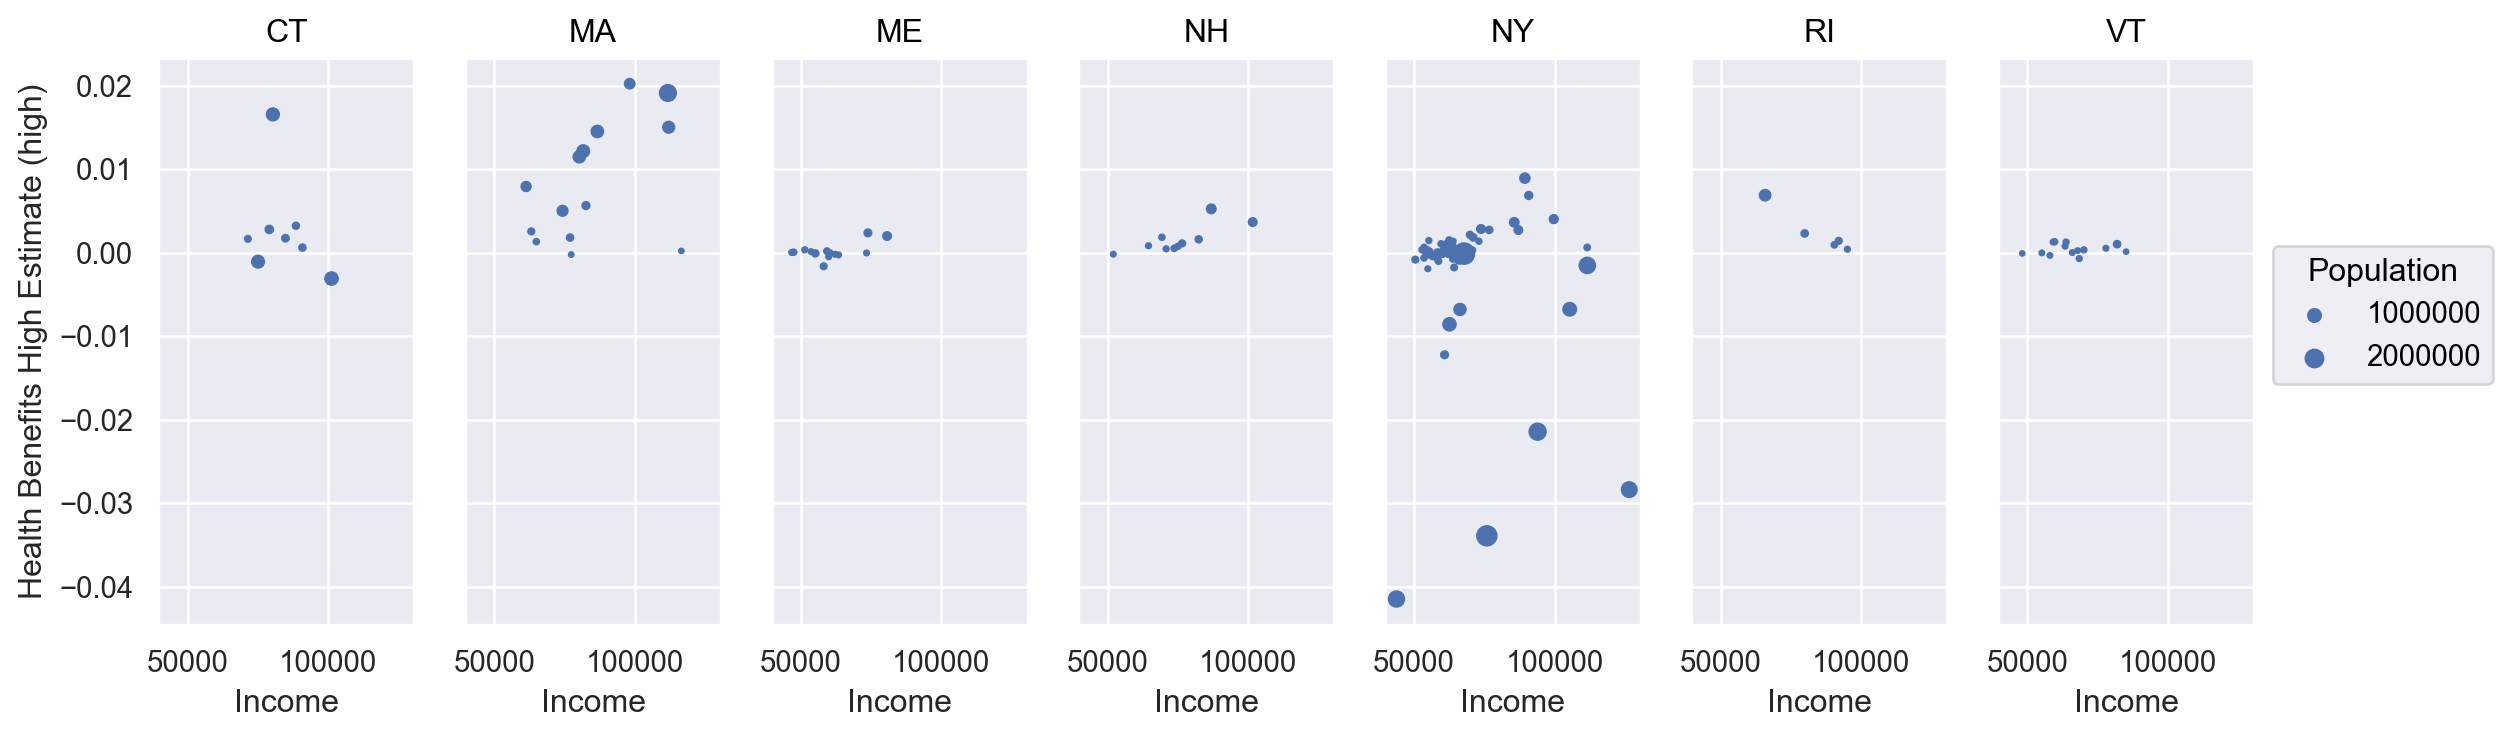

In [ ]:

(
    so.Plot(
        inner,
        x='Income',
        y='Health Benefits High Estimate (high)',
        # color='State',
        pointsize='Population')
    .add(so.Dot())
    .facet(col='State')
    .layout(size=(12, 4))
)

# Low Health Benefits upper bound graph

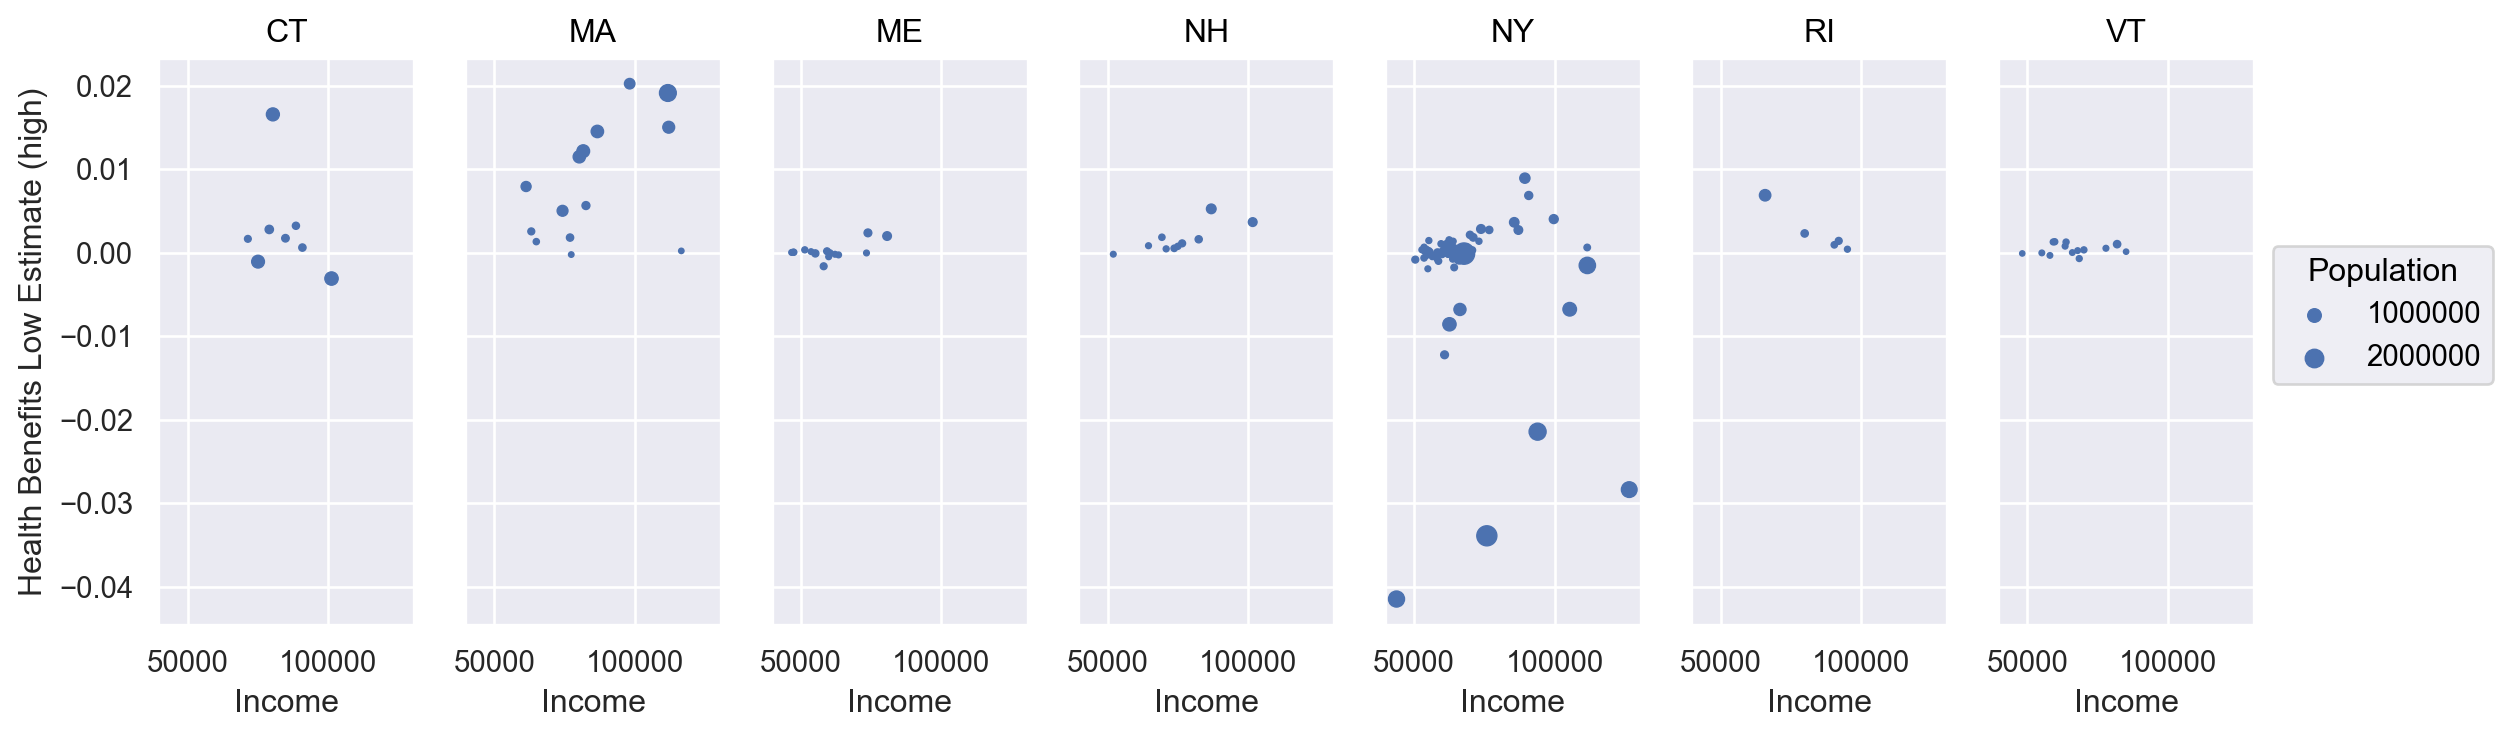

In [48]:

(
    so.Plot(
        inner,
        x='Income',
        y='Health Benefits Low Estimate (high)',
        # color='State',
        pointsize='Population')
    .add(so.Dot())
    .facet(col='State')
    .layout(size=(12, 4))
)

# Health Benefits of Carbon (high)

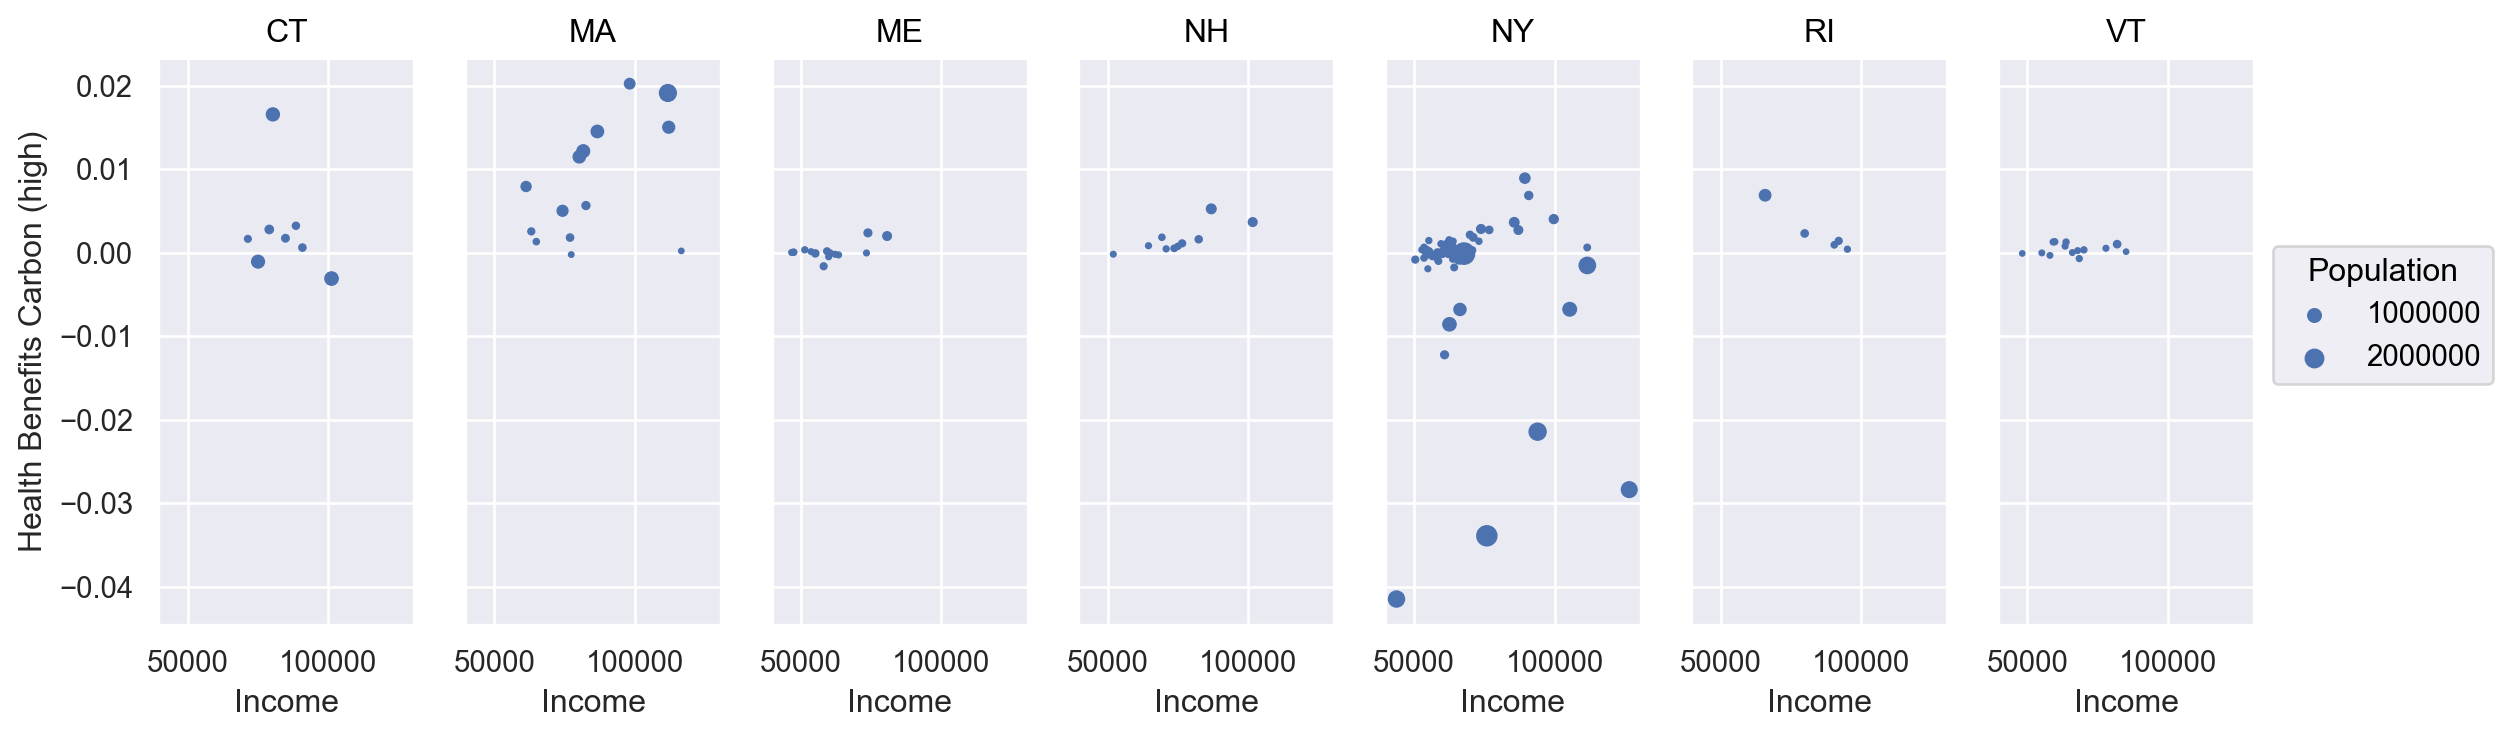

In [49]:

(
    so.Plot(
        inner,
        x='Income',
        y='Health Benefits Carbon (high)',
        # color='State',
        pointsize='Population')
    .add(so.Dot())
    .facet(col='State')
    .layout(size=(12, 4))
)

# Original Optimization health impacts

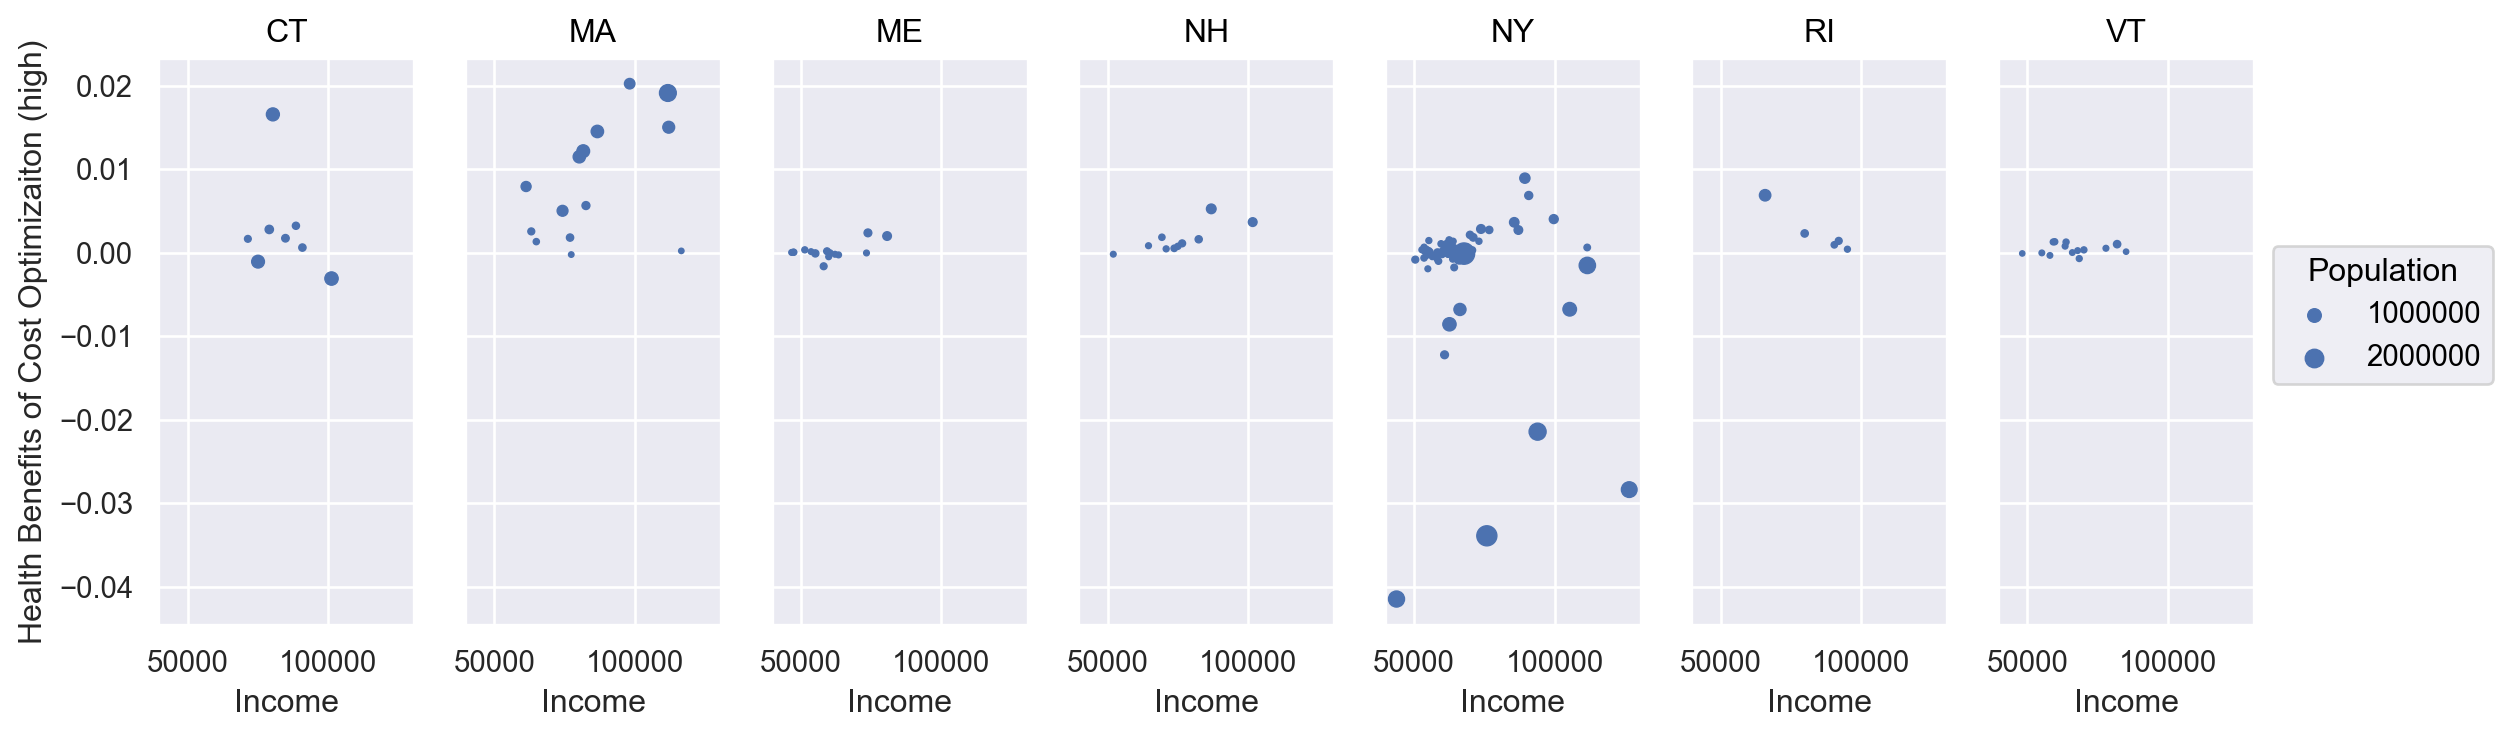

In [51]:

(
    so.Plot(
        inner,
        x='Income',
        y='Health Benefits of Cost Optimizaiton (high)',
        # color='State',
        pointsize='Population')
    .add(so.Dot())
    .facet(col='State')
    .layout(size=(12, 4))
)

## Mix with High Health Cost

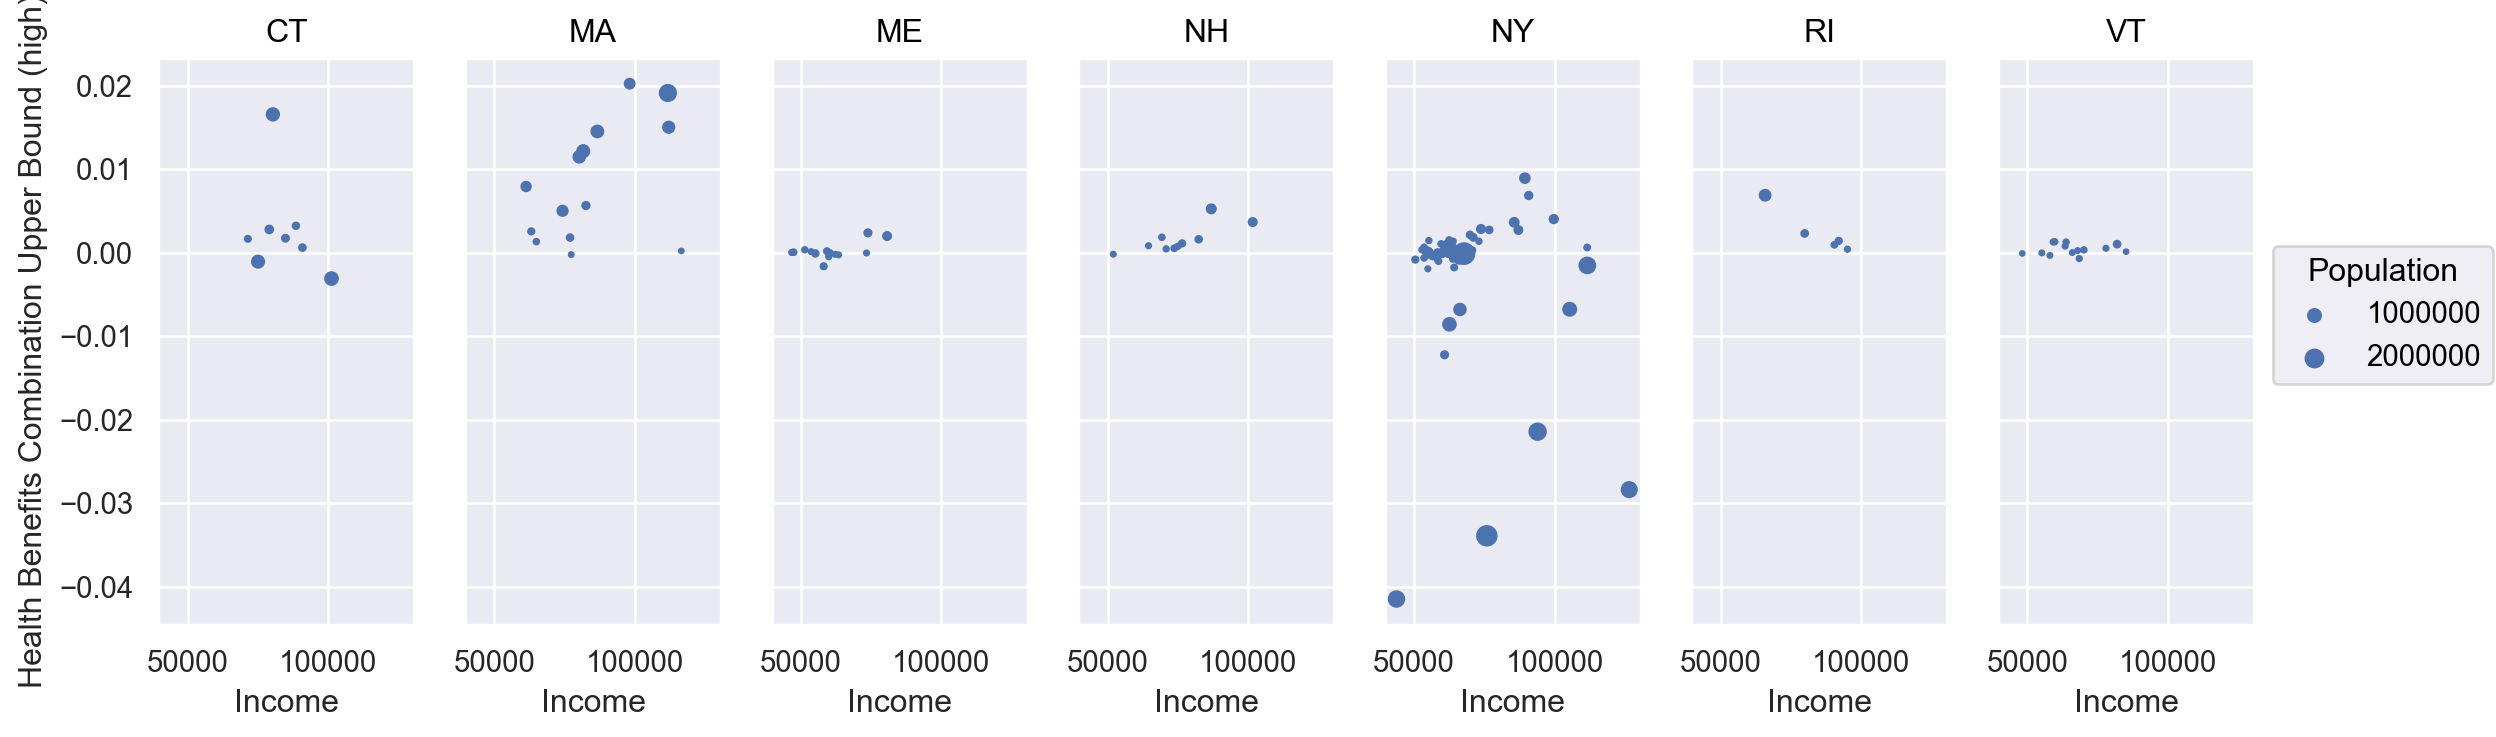

In [56]:
(
    so.Plot(
        inner,
        x='Income',
        y='Health Benefits Combination Upper Bound (high)',
        # color='State',
        pointsize='Population')
    .add(so.Dot())
    .facet(col='State')
    .layout(size=(12, 4))
)